# Polish Fake News Detection with BERT 📰🚨

- **Author:** *Mariusz Wiśniewski*
- **Date created:** *February 9th, 2023*
- **Last modified:** *February 9th, 2023*

## Overview

This notebook presents the code to fine-tune BERT for the task of fake news detection in Polish articles.

### Libraries Used

- [Tensorflow 🔥](https://www.tensorflow.org)
- [Transformers 🤗](https://huggingface.co/docs/transformers/index)
- [scikit-learn 🔬](https://scikit-learn.org/stable/)

### References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding 📃](https://arxiv.org/abs/1810.04805)
- [Polish Fake News Detector 📑](https://github.com/Nexer8/Polish_Fake_News_Detector)
- [Fake News : Basic work Tensorflow with Bert 📓](https://www.kaggle.com/code/jerifate/fake-news-basic-work-tensorflow-with-bert)

# Notebook Setup

## Import Statements

In [1]:
import os
import random
from ast import literal_eval

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import BertConfig, BertTokenizer, TFBertModel
from wordcloud import WordCloud

## Random Seed for Reproducibility

In [2]:
seed = 27

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Project Configuration

In [3]:
config = {
    "learning_rate": 1e-5,
    "min_learning_rate": 1e-8,
    "epochs": 200,
    "n_classes": 2,
    "batch_size": 32,
    "test_batch_size": 32,
    "max_length": 60,
}

In [4]:
plt.rcParams.update({"font.size": 16})
sn.set_palette("deep")

# Dataset

The data is given in the `.csv` format. It containts 998 fake and 2,571 real news articles scrapped from the web. `clean_text` contains already lemmatized and tokenized text.

## Loading Data and Preprocessing

In [5]:
data_df = pd.read_csv(
    "/kaggle/input/polish-fake-news/clean.csv", converters={"clean_text": literal_eval}
)
data_df.head()

,Unnamed: 0,content,author,label,uppercase%,exclamation_mark%,question_mark%,quotation_mark%,punctuation%,length,sentiment,positive_words%,negative_words%,clean_text
0,0,O ile my podnieśliśmy pensję minimalną w czasi...,Izabela Leszczyna,0,1.639344,0.0,1.639344,0.0,6.557377,61,0,0.000000,0.0,"[o, ile, my, podnieść, być, pensja, minimalny,..."
1,1,W rankingu praworządności World Justice Projec...,Hanna Gill-Piątek,1,6.172840,0.0,0.000000,0.0,2.469136,81,1,10.000000,0.0,"[w, ranking, praworządność, World, Justice, Pr..."
2,2,Na Uniwersytecie Warszawskim powstał taki rapo...,Dariusz Rosati,1,2.922078,0.0,0.000000,0.0,3.246753,308,0,0.000000,0.0,"[na, uniwersytet, Warszawskie, powstać, taki, ..."
3,3,Średnia emerytura w Polsce kobiet i mężczyzn r...,Małgorzata Kidawa-Błońska,1,3.571429,0.0,0.000000,0.0,1.785714,56,0,0.000000,0.0,"[średnia, emerytura, w, Polska, kobieta, i, mę..."
4,4,Proszę mi pokazać (…) jedną osobę skazaną prze...,Paweł Kukiz,0,3.720930,0.0,0.000000,0.0,6.046512,215,1,3.448276,0.0,"[prosić, mi, pokazać, …, jeden, osoba, skazana..."


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3569 entries, 0 to 3568
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3569 non-null   int64  
 1   content            3569 non-null   object 
 2   author             3569 non-null   object 
 3   label              3569 non-null   int64  
 4   uppercase%         3569 non-null   float64
 5   exclamation_mark%  3569 non-null   float64
 6   question_mark%     3569 non-null   float64
 7   quotation_mark%    3569 non-null   float64
 8   punctuation%       3569 non-null   float64
 9   length             3569 non-null   int64  
 10  sentiment          3569 non-null   int64  
 11  positive_words%    3569 non-null   float64
 12  negative_words%    3569 non-null   float64
 13  clean_text         3569 non-null   object 
dtypes: float64(7), int64(4), object(3)
memory usage: 390.5+ KB


In [7]:
print(f'[author] {data_df["author"][0]}')
print(f'[content] {data_df["content"][0]}')
print(f'[label] {"True" if data_df["label"][0] == 1 else "Fake"}')

[author] Izabela Leszczyna
[content] O ile my podnieśliśmy pensję minimalną w czasie 8 lat? (…) o ponad 90 proc.
[label] Fake


In [8]:
clean_texts = data_df["clean_text"].apply(lambda x: " ".join(x)).tolist()
labels = data_df["label"].tolist()

## Exploratory Data Analysis(EDA) with Visualization

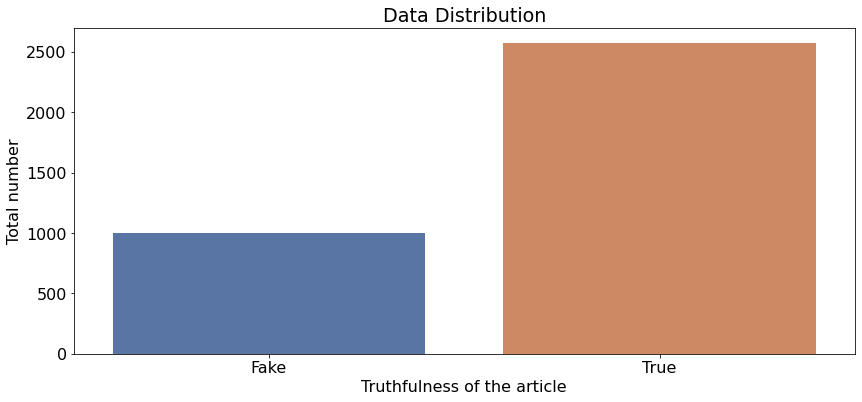

In [9]:
fig = plt.figure(figsize=(14, 6))
ax = sn.countplot(x=data_df["label"].map({0: "Fake", 1: "True"}))
ax.set(xlabel="Truthfulness of the article", ylabel="Total number")
plt.title("Data Distribution")
plt.show()

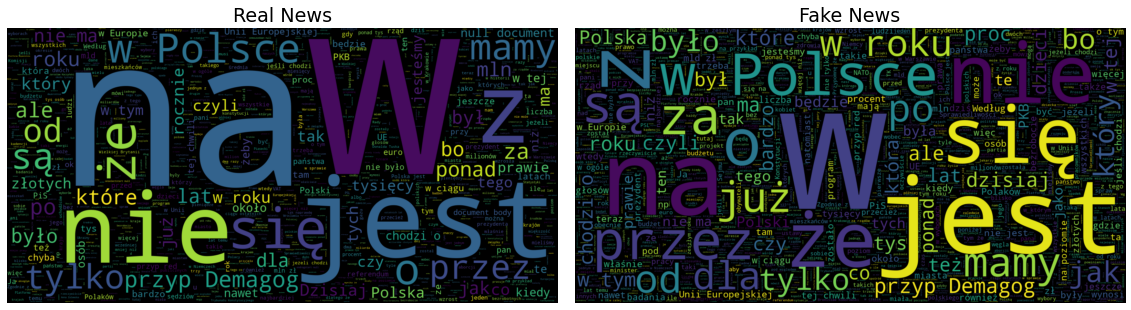

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data_df[data_df.label == 0].content)
)
ax[0].set_title("Real News")
ax[0].imshow(wc, interpolation="bilinear")
ax[0].axis("off")

wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(data_df[data_df.label == 1].content)
)
ax[1].set_title("Fake News")
ax[1].imshow(wc, interpolation="bilinear")
ax[1].axis("off")

plt.tight_layout()
plt.show()

## Build Train, Validation, and Test Datasets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    clean_texts, labels, test_size=0.2, random_state=1,
    stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1,
    stratify=y_train
)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(
    "Number of samples:\n"
    f"train: {len(X_train)} ({round(float(len(X_train)) / float(len(labels)) * 100.0)}% of the dataset)\n"
    f"validation: {len(X_val)} ({round(float(len(X_val)) / float(len(labels)) * 100.0)}% of the dataset)\n"
    f"test: {len(X_test)} ({round(float(len(X_test)) / float(len(labels)) * 100.0)}% of the dataset)"
)

Number of samples:
train: 2141 (60% of the dataset)
validation: 714 (20% of the dataset)
test: 714 (20% of the dataset)


# Model

In [12]:
model_name = "bert-base-uncased"
bert_config = BertConfig.from_pretrained(model_name)
bert_config.hidden_dropout_prob = 0.35
bert_config.attention_probs_dropout_prob = 0.35
bert_layers = TFBertModel.from_pretrained(model_name, config=bert_config)
bert_tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [13]:
def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for i in range(len(data)):
        encoded = bert_tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
        )

        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    return np.array(input_ids), np.array(attention_masks)

In [14]:
train_input_ids, train_attention_masks = bert_encode(
    X_train, config["max_length"])
val_input_ids, val_attention_masks = bert_encode(X_val, config["max_length"])
test_input_ids, test_attention_masks = bert_encode(
    X_test, config["max_length"])

In [15]:
def get_model(max_length=60):
    """Build a 3D convolutional neural network model."""

    input_ids = Input((max_length,), dtype="int32", name="input_ids")
    attention_masks = Input(
        (max_length,), dtype="int32", name="attention_masks")

    output = bert_layers([input_ids, attention_masks])
    x = Dense(units=32, activation="relu")(output[1])
    x = Dropout(0.35)(x)
    outputs = Dense(units=config["n_classes"], activation="softmax")(x)

    return Model([input_ids, attention_masks], outputs, name="Bert")


model = get_model(max_length=config["max_length"])
model.summary()

Model: "Bert"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           24608       tf_bert_model[0][1]           

## Class Weights

In [16]:
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",  # balanced for computing weights based on class count
    classes=np.unique(y_train),
    y=y_train,
)
class_weights = dict(zip(np.unique(y_train), class_weights))
print(class_weights)

{0: 1.790133779264214, 1: 0.6937783538561244}


## Model Training

In [17]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=config["learning_rate"]),
    metrics=["acc"],
)

model.fit(
    [train_input_ids, train_attention_masks],
    tf.one_hot(y_train, depth=config['n_classes']),
    validation_data=([val_input_ids, val_attention_masks],
                     tf.one_hot(y_val, depth=config['n_classes'])),
    epochs=config["epochs"],
    class_weight=class_weights,
    shuffle=True,
    batch_size=config["batch_size"],
    verbose=2,
    callbacks=[
        ModelCheckpoint("best.h5", save_best_only=True,
                        monitor="val_loss", mode="min"),
        ReduceLROnPlateau(
            monitor="val_loss",
            mode="min",
            patience=7,
            factor=0.5,
            min_lr=config["min_learning_rate"],
        ),
        EarlyStopping(
            monitor="val_loss",
            mode="min",
            patience=20,
            restore_best_weights=True,
        ),
    ],
)

Epoch 1/200
67/67 - 36s - loss: 0.7126 - acc: 0.4638 - val_loss: 0.7020 - val_acc: 0.4300
Epoch 2/200
67/67 - 18s - loss: 0.6993 - acc: 0.5488 - val_loss: 0.7074 - val_acc: 0.3109
Epoch 3/200
67/67 - 18s - loss: 0.6968 - acc: 0.5142 - val_loss: 0.6962 - val_acc: 0.4076
Epoch 4/200
67/67 - 18s - loss: 0.6949 - acc: 0.5600 - val_loss: 0.6870 - val_acc: 0.6597
Epoch 5/200
67/67 - 18s - loss: 0.6949 - acc: 0.3900 - val_loss: 0.6971 - val_acc: 0.3571
Epoch 6/200
67/67 - 18s - loss: 0.6940 - acc: 0.4204 - val_loss: 0.6957 - val_acc: 0.4230
Epoch 7/200
67/67 - 18s - loss: 0.6933 - acc: 0.4433 - val_loss: 0.6989 - val_acc: 0.4258
Epoch 8/200
67/67 - 18s - loss: 0.6944 - acc: 0.4773 - val_loss: 0.6910 - val_acc: 0.6204
Epoch 9/200
67/67 - 18s - loss: 0.6930 - acc: 0.4928 - val_loss: 0.6909 - val_acc: 0.6429
Epoch 10/200
67/67 - 18s - loss: 0.6929 - acc: 0.4680 - val_loss: 0.6828 - val_acc: 0.6947
Epoch 11/200
67/67 - 18s - loss: 0.6916 - acc: 0.5460 - val_loss: 0.6737 - val_acc: 0.7157
Epoch 12

## Visualizing Training History

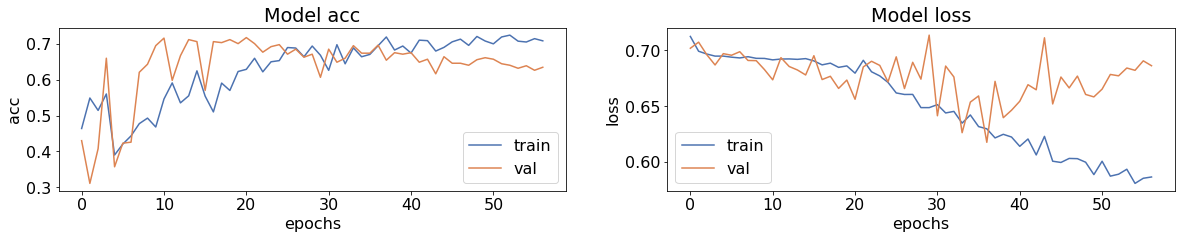

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f"val_{metric}"])
    ax[i].set_title(f"Model {metric}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Model Evaluation

In [19]:
y_pred = [
    np.argmax(x)
    for x in model.predict(
        [test_input_ids, test_attention_masks], batch_size=config["test_batch_size"]
    )
]

## Classification Report

In [20]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.524     0.110     0.182       200
           1      0.735     0.961     0.833       514

    accuracy                          0.723       714
   macro avg      0.629     0.536     0.507       714
weighted avg      0.676     0.723     0.651       714



## Confusion Matrix

<AxesSubplot:>

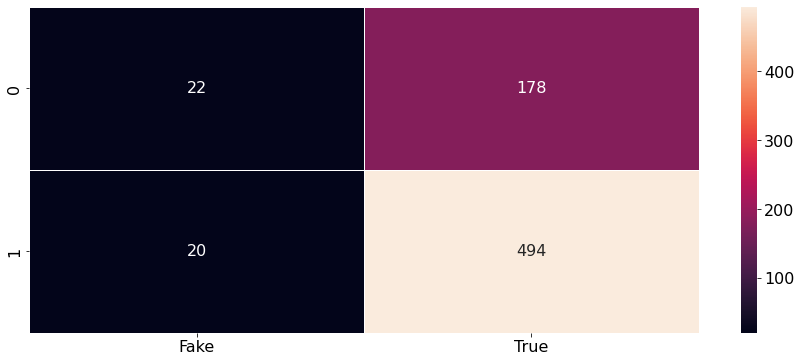

In [21]:
cfsn_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(
    cfsn_matrix, index=range(config["n_classes"]), columns=["Fake", "True"]
)
plt.figure(figsize=(15, 6))
sn.heatmap(df_cm, annot=True, linewidths=0.5, fmt="d")